# Project Critique Aribnb Dataset

## Dataset Description
### Setup and Imports

In [1]:
# load packages
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use('seaborn-whitegrid')

random_state = 26498

In [2]:
# import csv of anonymized data
anon_data = pd.read_csv("anonymized_airbnb.csv")
anon_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,*****,*****,-1540419183100330906,*****,Brooklyn,Kensington,*****,*****,Private room,157.324234,3.548874,6.920243,2018-10,0.21,6,365
1,*****,*****,-6303625318003254822,*****,Manhattan,Midtown,*****,*****,Entire home/apt,222.991412,1.552826,46.989945,2019-05,0.38,2,355
2,*****,*****,2655665583548708572,*****,Manhattan,Harlem,*****,*****,Private room,154.848218,3.455304,0.698164,NaN,NaN,1,365
3,*****,*****,-2939139632100285860,*****,Brooklyn,Clinton Hill,*****,*****,Entire home/apt,87.730973,-9.733857,270.073743,2019-07,4.64,1,194
4,*****,*****,1918944794498209498,*****,Manhattan,East Harlem,*****,*****,Entire home/apt,75.474851,8.164240,4.983751,2018-11,0.10,1,0


## Initial Thoughts

To reiterate, we will summarize the anonymization approach that was used in this group's work. Many potentially identifying attributes were suppressed. It is also important to note that `host_id` was hashed - they still exist, but are now generalized and unique. Review dates were generalized to `months` and `minimum_nights`, while `number_of_reviews` has output pertubation. In the process of doing this part of our project we also discovered that `neighbourhood` was generalized to include an "other" value for sufficiently unique records.

Our first reaction was that hashing the `host_id` is counteractive to the k-anonymization done on neighborhood and last review categories. Having a unique `host_id` still makes each row identifiable by `host`, even if that host is not know.

## Deanonymization

### Linking Attack


Number of unique hosts in Staten Island: 254


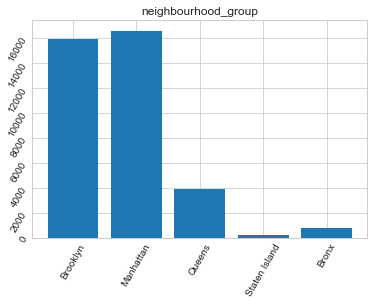

In [3]:
def plot_column_bar(df, col_name=''):
    freqs = Counter(df[col_name])
    centers = range(len(freqs))
    plt.bar(centers, freqs.values(), align='center', tick_label=list(freqs.keys()))
    plt.tick_params(rotation=60)
    plt.title(col_name)

anon_data_uniquesub = anon_data.drop_duplicates(subset=['host_id'])

plot_column_bar(anon_data_uniquesub, 'neighbourhood_group')
hosts_stat = len(set(anon_data_uniquesub[
    anon_data_uniquesub['neighbourhood_group'] == 'Staten Island'
]['host_id']))
print(f"Number of unique hosts in Staten Island: {hosts_stat!s}")

Number of unique hosts in Staten Island with Shared Rooms: 1


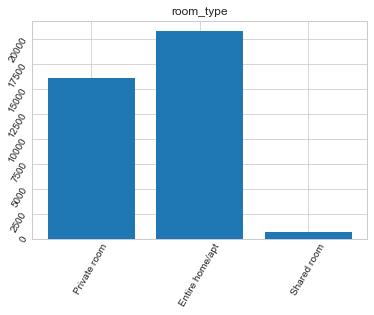

In [4]:
plot_column_bar(anon_data_uniquesub, 'room_type')
hosts_stat = len(set(anon_data_uniquesub[
    (anon_data_uniquesub['neighbourhood_group'] == 'Staten Island')
    & (anon_data_uniquesub['room_type'] == 'Shared room')
]['host_id']))
print(f"Number of unique hosts in Staten Island with Shared Rooms: {hosts_stat!s}")

There is only one host in Staten Island with a shared room. Let's find out what neighborhood they are in.

In [5]:
anon_data_uniquesub[
    (anon_data_uniquesub['neighbourhood_group'] == 'Staten Island')
    & (anon_data_uniquesub['room_type'] == 'Shared room')
]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
29852,*****,*****,166516043984057418,*****,Staten Island,other,*****,*****,Shared room,21.210083,4.394432,-1.334582,2018-02,0.06,1,0


It is here that we discover how this group has generalized the `neighbourhood` column. Since this record was very unique, they changed its neighbourhood value to `"other"`.

Generally we can say that this record indicates that the listing is either for a very small room or is located in a low income area, given its unusually low price.

We can go further by looking at the least common neighborhoods listed:

In [6]:
neighborhoodfreqs = Counter(anon_data_uniquesub[anon_data_uniquesub['neighbourhood_group'] == "Staten Island"]['neighbourhood'])
pprint(list(reversed(neighborhoodfreqs.most_common())))

[('West Brighton', 9),
 ('Clifton', 9),
 ('Arrochar', 9),
 ('Concord', 10),
 ('Randall Manor', 12),
 ('Stapleton', 19),
 ('Tompkinsville', 23),
 ('St. George', 36),
 ('other', 127)]


We cross-referenced this with a publically available [list of Staten Island neighborhoods](https://en.wikipedia.org/wiki/List_of_Staten_Island_neighborhoods). There are 133 cities in Staten Island, and eight are listed here. 

We can attack the top three neighborhoods as they have the fewest unique hosts.

In [7]:
anon_data_uniquesub[
    (anon_data_uniquesub['neighbourhood'] == 'West Brighton')
    | (anon_data_uniquesub['neighbourhood'] == 'Clifton')
    | (anon_data_uniquesub['neighbourhood'] == 'Arrochar')
]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
702,*****,*****,6392895369810300628,*****,Staten Island,Arrochar,*****,*****,Entire home/apt,250.130560,5.521712,22.160609,2019-05,0.26,4,333
866,*****,*****,1035452390453523158,*****,Staten Island,Clifton,*****,*****,Private room,54.909607,2.474375,48.304449,2019-06,0.56,1,352
4248,*****,*****,4636685011352948729,*****,Staten Island,Clifton,*****,*****,Entire home/apt,69.948211,6.388929,0.495071,2014-04,0.02,1,0
5387,*****,*****,6329633848596035616,*****,Staten Island,Clifton,*****,*****,Entire home/apt,62.672254,1.117754,239.618717,2019-06,4.09,1,256
6941,*****,*****,938404173542671742,*****,Staten Island,West Brighton,*****,*****,Entire home/apt,66.983193,-7.160376,192.149395,2019-06,3.63,1,231
8023,*****,*****,7946963478648340971,*****,Staten Island,West Brighton,*****,*****,Private room,25.377034,25.664600,7.622301,2019-03,0.12,2,354
14831,*****,*****,-6627210699540527405,*****,Staten Island,Clifton,*****,*****,Entire home/apt,89.111911,4.208913,90.248108,2019-06,2.04,1,155
15609,*****,*****,990080670117381313,*****,Staten Island,Clifton,*****,*****,Entire home/apt,176.455428,-1.678484,107.132301,2019-06,2.78,1,298
17443,*****,*****,-653420403790779347,*****,Staten Island,Clifton,*****,*****,Entire home/apt,136.858855,2.052015,80.513576,2019-06,2.26,1,310
18699,*****,*****,-2385296255307306106,*****,Staten Island,West Brighton,*****,*****,Entire home/apt,116.790048,6.693674,94.507900,2019-07,2.82,5,362


Some of the records in this subset are very highly booked (that is, they are **outliers** based on `availability_365`). We could attempt to compare the details of this listing with other information about a particular host's income and frequency of booking for certain properties in the records' associated neighborhoods.

This pursuit may identify properties or their hosts if fruitful.

### Homogeneity Attack

We find that there is very little if any potential for a homogeneity attack on the anonymized dataset. There are too few columns which produce equivalence classes that would be helpful -- even if there were, (say we chose `month` as the basis for our equivalence classes) 

## Potential Disclosure

In class we talked about three main types of disclosure.

* Membership Disclosure
* Identity Disclosure
* Sensitive Attribute Disclosure

Membership disclosure implies that you are able to conclude that a case is a member of the data set. Identity disclosure means that a specific row is identified as a certain case and sensitive attribute disclosure means you can find out a certain case's sentive attributes.

We have already examined two ways of attacking to create disclosure: linking and homogeneity. One example of a successful attack was the combination of the Staten Island neighborhoud with the shared room type. If I as an attacker had the information to link with this I would be able to identify exactly who this is and all three disclosure types would happen.

When looking for discolsure another possible attack option is to look at the number of listings from a host. This can be seen as a sort of graph degrees issue, because you can see how man properties a single host is connected to.

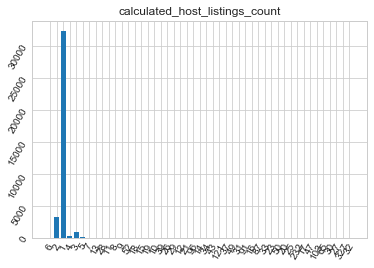

In [9]:
plot_column_bar(anon_data_uniquesub, 'calculated_host_listings_count')

As you can see above if you knew someone was in the dataset and they had a large number of listings then they could be easily found within the data set. It is clear that there are a lot of holes in this data set mostly from outliers not being taken care of. If we extracted these outliers and removed them from the dataset then this anonmyization would actually be quite good and difficult to find any disclosure that existed.

## Overall Rating

The approach taken overall was quite good. There were sound methods implemented and the differential privacy implemented on the numerical data was quite helpful in anonymization. THe biggest issue in the group's approach to anonmyziation is that they looked at all the basic concepts and implemneted them, but neglected to look at outliers. This method of anon